In [26]:
'hello'

'hello'

In [27]:
# Connect to PostgreSQL using environment variables
import os
from dotenv import load_dotenv
import psycopg2

# Load .env file
load_dotenv()

# Load .env file
load_dotenv()

# Read values
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")

print("Loaded from .env:")
print(host, port, dbname, user, password)

Loaded from .env:
localhost 5432 client_query_db postgres admin


In [28]:
# Connect to PostgreSQL and create tables

import os
from dotenv import load_dotenv
import psycopg2

load_dotenv()

# Read from .env file
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")

# Connect to PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

conn.autocommit = True
cur = conn.cursor()

# Create users table
cur.execute("""
CREATE TABLE IF NOT EXISTS users (
    id SERIAL PRIMARY KEY,
    username VARCHAR(100) NOT NULL UNIQUE,
    hashed_password VARCHAR(255) NOT NULL,
    role VARCHAR(20) CHECK (role IN ('Admin', 'Client', 'Support')) NOT NULL
);
""")

# Create queries table
cur.execute("""
CREATE TABLE IF NOT EXISTS queries (
    id SERIAL PRIMARY KEY,
    client_email VARCHAR(255),
    client_mobile VARCHAR(20),
    query_heading VARCHAR(255),
    query_description TEXT,
    status VARCHAR(20) CHECK (status IN ('Open', 'Closed')) DEFAULT 'Open',
    date_raised TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    date_closed TIMESTAMP
);
""")

print("✅ Tables created successfully!")

cur.close()
conn.close()


✅ Tables created successfully!


In [29]:
# Load and inspect CSV data

import pandas as pd

csv_path = r"C:\Users\Amirtha\OneDrive\Desktop\Project\client_query_management_system\data\synthetic_client_queries.csv"

df = pd.read_csv(csv_path)
print(df.columns)


Index(['query_id', 'mail_id', 'mobile_number', 'query_heading',
       'query_description', 'status', 'query_created_time',
       'query_closed_time'],
      dtype='object')


In [30]:
# Load CSV data into PostgreSQL queries table

import os
import psycopg2
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# 1. Load env file
load_dotenv()

host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")

# 2. Connect to PostgreSQL
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)
conn.autocommit = True
cursor = conn.cursor()

# 3. Load CSV
csv_path = r"C:\Users\Amirtha\OneDrive\Desktop\Project\client_query_management_system\data\synthetic_client_queries.csv"
data = pd.read_csv(csv_path)



# 4. Replace NaN with None (Postgres NULL)
data = data.replace({np.nan: None})

insert_sql = """
    INSERT INTO queries (
        client_email,
        client_mobile,
        query_heading,
        query_description,
        status,
        date_raised,
        date_closed
    )
    VALUES (%s, %s, %s, %s, %s, %s, %s);
"""

for _, row in data.iterrows():
    client_email      = row.get("mail_id")
    client_mobile     = row.get("mobile_number")
    query_heading     = row.get("query_heading")
    query_description = row.get("query_description")
    status_raw        = row.get("status")
    date_raised       = row.get("query_created_time")
    date_closed       = row.get("query_closed_time")

    # --- clean status to satisfy CHECK (Open / Closed) ---
    if status_raw is None:
        status = "Open"
    else:
        s = str(status_raw).strip().lower()
        if s in ("open", "opened"):
            status = "Open"
        elif s in ("closed", "close", "resolved"):
            status = "Closed"
        else:
            status = "Open"

    cursor.execute(
        insert_sql,
        (
            client_email,
            client_mobile,
            query_heading,
            query_description,
            status,
            date_raised,
            date_closed,
        )
    )

print("✅ CSV data loaded into PostgreSQL queries table!")

cursor.close()
conn.close()


✅ CSV data loaded into PostgreSQL queries table!


In [5]:
# Create a new user with hashed password for Admin/Support/Client

import os
import psycopg2
import hashlib
from dotenv import load_dotenv

# Load env file
load_dotenv()

# Read values from env
HOST = os.getenv("DB_HOST")
PORT = os.getenv("DB_PORT")
DB   = os.getenv("DB_NAME")
USER = os.getenv("DB_USER")
PWD  = os.getenv("DB_PASSWORD")

# Hash function
def make_hash(password):
    return hashlib.sha256(password.encode()).hexdigest()

# Connect to PostgreSQL
conn = psycopg2.connect(
    host=HOST,
    port=PORT,
    dbname=DB,
    user=USER,
    password=PWD
)
cursor = conn.cursor()

print("\n=== CREATE NEW USER ===\n")

username_input = input("Enter username: ").strip()
password_input = input("Enter password: ").strip()
role_input     = input("Enter role (Client / Support / Admin): ").strip()

# Normalize role
role_lower = role_input.lower()

if role_lower == "client":
    role = "Client"
elif role_lower == "support":
    role = "Support"
elif role_lower == "admin":
    role = "Admin"
else:
    print("Invalid role! Must be Client / Support / Admin")
    cursor.close()
    conn.close()
    raise SystemExit()

# Format username
username = username_input.upper()

# Hash password
hashed_password = make_hash(password_input)

# Insert user
cursor.execute(
    "INSERT INTO users (username, hashed_password, role) VALUES (%s, %s, %s)",
    (username, hashed_password, role)
)
conn.commit()

print("\n✔ USER CREATED SUCCESSFULLY!\n")
print("Username:", username)
print("Original Password:", password_input)
print("Hashed Password:", hashed_password)
print("Role:", role)

cursor.close()
conn.close()



=== CREATE NEW USER ===


✔ USER CREATED SUCCESSFULLY!

Username: SANJAY K
Original Password: admin
Hashed Password: 8c6976e5b5410415bde908bd4dee15dfb167a9c873fc4bb8a81f6f2ab448a918
Role: Client


In [6]:
# To verify user login

import os
import psycopg2
import hashlib
from dotenv import load_dotenv

# Load .env values
load_dotenv()

# Hash function
def make_hash(password):
    return hashlib.sha256(password.encode()).hexdigest()

# Connect to DB
conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD")
)
cursor = conn.cursor()

# ----- USER INPUT -----
username = input("Enter username: ").upper()
password = input("Enter password: ")
role_raw = input("Enter role (Client / Support /Admin): ")

# Normalize role
role_raw = role_raw.strip().lower()
if role_raw == "client":
    role = "Client"
elif role_raw == "support":
    role = "Support"
elif role_raw == "admin":
    role = "Admin"
else:
    print("Invalid role!")
    exit()

# Hash the password
hashed = make_hash(password)

# ----- CHECK LOGIN -----
cursor.execute(
    "SELECT * FROM users WHERE username=%s AND hashed_password=%s AND role=%s",
    (username, hashed, role)
)

user = cursor.fetchone()

cursor.close()
conn.close()

# ----- DISPLAY RESULT -----
if user:
    print("\n🎉 LOGIN SUCCESSFUL!")
    print("User ID  :", user[0])
    print("Username :", user[1])
    print("Role     :", user[3])
else:
    print("\n LOGIN FAILED!")
    print("Please check:")
    print("- Username")
    print("- Password")
    print("- Role (Client / Support)")



🎉 LOGIN SUCCESSFUL!
User ID  : 1
Username : ADMIN
Role     : Admin


In [1]:
# To insert a new client query

import psycopg2
from datetime import datetime

def insert_query():
    # Always create a fresh connection
    conn = psycopg2.connect(
        host="localhost",
        port=5432,
        dbname="client_query_db",
        user="postgres",
        password="admin"
    )
    cursor = conn.cursor()

    # Take input
    email = input("Enter client email: ")
    mobile = input("Enter mobile number: ")
    heading = input("Enter query heading: ")
    description = input("Enter query description: ")

    # Current time
    query_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Insert
    cursor.execute("""
        INSERT INTO queries (client_email, client_mobile, query_heading, query_description, date_raised, status)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, (email, mobile, heading, description, query_time, "Open"))

    conn.commit()
    cursor.close()
    conn.close()

    print("\n✔ QUERY INSERTED SUCCESSFULLY!")
    print("Email      :", email)
    print("Mobile     :", mobile)
    print("Heading    :", heading)
    print("Description:", description)
    print("Status     : Open")

# Call function
insert_query()



✔ QUERY INSERTED SUCCESSFULLY!
Email      : hello@gmail.com
Mobile     : 7894561230
Heading    : fix the issue
Description: fix it
Status     : Open


In [ ]:
# To update the status of an existing query

import psycopg2
from datetime import datetime

# Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="client_query_db",
    user="postgres",
    password="admin"
)
cursor = conn.cursor()

# ----- User Input -----
query_id = input("Enter Query ID to update: ")
new_status = input("Enter new status (Open / Closed): ").capitalize()

# Validate status
if new_status not in ["Open", "Closed"]:
    print(" Invalid status! Only 'Open' or 'Closed' allowed.")
    exit()

# If Closed → update closing time
if new_status == "Closed":
    close_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
else:
    close_time = None  # Clear closing time if reopened

# ----- Update Query -----
cursor.execute("""
    UPDATE queries
    SET status = %s, date_closed = %s
    WHERE id = %s
""", (new_status, close_time, query_id))

conn.commit()

# ----- Output -----
print("\n✅ QUERY STATUS UPDATED SUCCESSFULLY!")
print("Query ID :", query_id)
print("New Status:", new_status)
print("Closed Time:", close_time)

cursor.close()
conn.close()



✅ QUERY STATUS UPDATED SUCCESSFULLY!
Query ID : 1
New Status: Closed
Closed Time: 2025-12-06 22:26:58


In [ ]:
# To fetch and display Open/Closed queries

import psycopg2
import pandas as pd

# Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="client_query_db",
    user="postgres",
    password="admin"
)

# Fetch ONLY Open queries
df_closed = pd.read_sql("""
    SELECT *
    FROM queries
    WHERE status = 'Closed'
    ORDER BY id DESC;
""", conn)

print("\n Closed QUERIES:")
print(df_closed)

# Display dataframe
df_closed


C:\Users\Amirtha\AppData\Local\Temp\ipykernel_28980\2929249172.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_closed = pd.read_sql("""



 Closed QUERIES:
        id                   client_email client_mobile       query_heading  \
0     5200          kenneth76@example.com    9953237970     Payment Failure   
1     5199      vaughnkristen@example.org     795334441         UI Feedback   
2     5198  mclaughlinmichael@example.net     312901852         Login Issue   
3     5197           robert82@example.net    2400038786   Technical Support   
4     5196             fhenry@example.org    2758293072     Payment Failure   
...    ...                            ...           ...                 ...   
5141     5             rmoore@example.net    8523755943         UI Feedback   
5142     4            wtaylor@example.com    4753393384         Data Export   
5143     3          cookmason@example.org    2686615523  Account Suspension   
5144     2           edward91@example.net    6369365581          Bug Report   
5145     1       joshuaoneill@example.net    6638686049          Bug Report   

                                q

,id,client_email,client_mobile,query_heading,query_description,status,date_raised,date_closed
0,5200,kenneth76@example.com,9953237970,Payment Failure,Payment failed due to card error.,Closed,2025-06-27,2025-07-05 00:00:00
1,5199,vaughnkristen@example.org,795334441,UI Feedback,Graphs too compressed on mobile view.,Closed,2025-07-15,2025-07-24 00:00:00
2,5198,mclaughlinmichael@example.net,312901852,Login Issue,Forgot my password and reset isn’t working.,Closed,2025-06-25,2025-07-04 00:00:00
3,5197,robert82@example.net,2400038786,Technical Support,Freezing during screen load.,Closed,2025-05-17,2025-05-20 00:00:00
4,5196,fhenry@example.org,2758293072,Payment Failure,EMI option not available anymore.,Closed,2025-05-03,2025-05-09 00:00:00
...,...,...,...,...,...,...,...,...
5141,5,rmoore@example.net,8523755943,UI Feedback,Icons not intuitive.,Closed,2025-06-19,2025-06-20 00:00:00
5142,4,wtaylor@example.com,4753393384,Data Export,Need monthly data dump in CSV.,Closed,2025-02-25,2025-03-07 00:00:00
5143,3,cookmason@example.org,2686615523,Account Suspension,Need help lifting restrictions.,Closed,2025-06-18,2025-06-19 00:00:00
5144,2,edward91@example.net,6369365581,Bug Report,Form validation not working properly.,Closed,2025-07-22,2025-08-01 00:00:00


In [ ]:
pip install matplotlib


  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.0-cp312-cp312-win_amd64.whl.metadata (115 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.0-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ------ --------------------------------- 1/6 [kiwisolver]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -

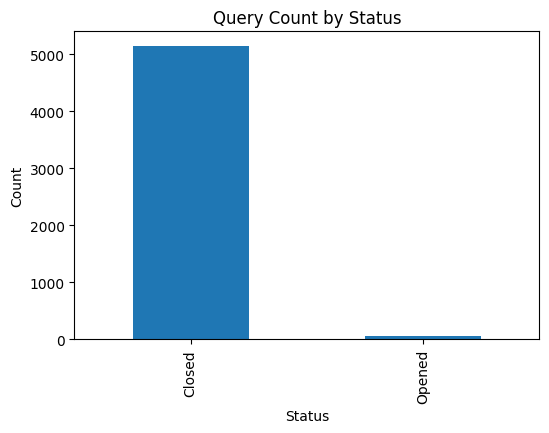

In [ ]:
# To visualize query status distribution in bar chart

import pandas as pd
import matplotlib.pyplot as plt
            
status_counts = df["status"].value_counts()

plt.figure(figsize=(6,4))
status_counts.plot(kind="bar")
plt.title("Query Count by Status")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()


c:\Users\Amirtha\OneDrive\Desktop\Project\client_query_management_system\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Amirtha\OneDrive\Desktop\Project\client_query_management_system\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


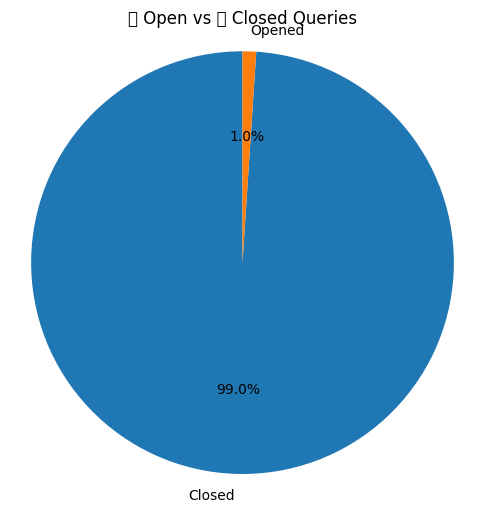

In [ ]:
# To visualize query status distribution as pie chart

status_counts = df["status"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(status_counts,
        labels=status_counts.index,
        autopct="%1.1f%%",
        startangle=90)
plt.title(" Open vs  Closed Queries")
plt.axis("equal")
plt.show()


C:\Users\Amirtha\AppData\Local\Temp\ipykernel_28980\2016865930.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Amirtha\OneDrive\Desktop\Project\client_query_management_system\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


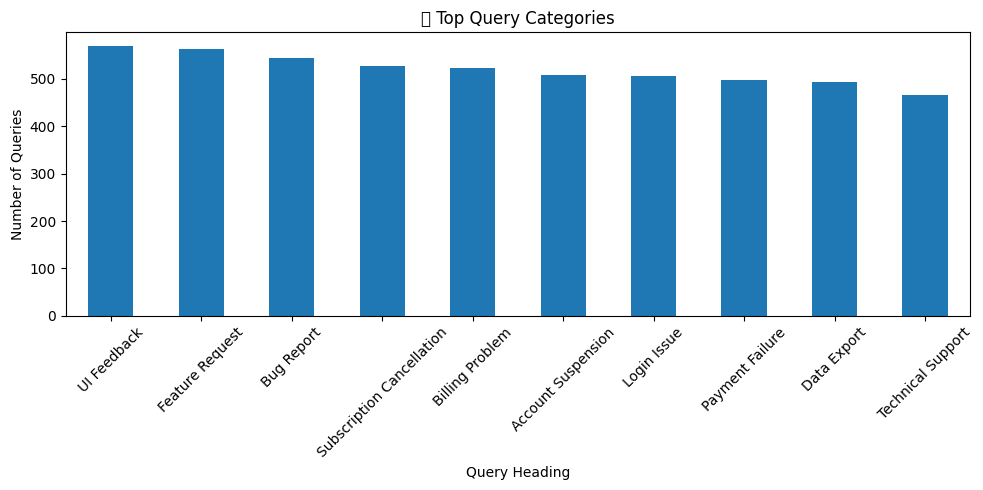

In [ ]:
# To visualize top query categories using bar chart

heading_counts = df["query_heading"].value_counts().head(10)

plt.figure(figsize=(10, 5))
heading_counts.plot(kind="bar")
plt.title(" Top Query Categories")
plt.xlabel("Query Heading")
plt.ylabel("Number of Queries")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
